> > ****Import libraries & data**

In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# Import model libraries
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Suppress the warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import the price data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/monthly.csv")
df.head()

,Date,Price
0,1950-01,34.73
1,1950-02,34.73
2,1950-03,34.73
3,1950-04,34.73
4,1950-05,34.73


In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
df.shape

(847, 2)

**Exploratory Data Analysis**

**Understanding the data******

In [ ]:
print(f"Date range of gold prices available from - {df.loc[:,'Date'][0]} to {df.loc[:,'Date'][len(df)-1]}")

Date range of gold prices available from - 1950-01 to 2020-07


In [ ]:
date = pd.date_range(start='1/1/1950', end='8/1/2020', freq='M')
date

DatetimeIndex(['1950-01-31', '1950-02-28', '1950-03-31', '1950-04-30',
               '1950-05-31', '1950-06-30', '1950-07-31', '1950-08-31',
               '1950-09-30', '1950-10-31',
               ...
               '2019-10-31', '2019-11-30', '2019-12-31', '2020-01-31',
               '2020-02-29', '2020-03-31', '2020-04-30', '2020-05-31',
               '2020-06-30', '2020-07-31'],
              dtype='datetime64[ns]', length=847, freq='M')

In [ ]:
df['month'] = date
df.drop('Date',axis=1,inplace=True)
df = df.set_index('month')
df.tail()

,Price
month,
1950-01-31,34.73
1950-02-28,34.73
1950-03-31,34.73
1950-04-30,34.73
1950-05-31,34.73


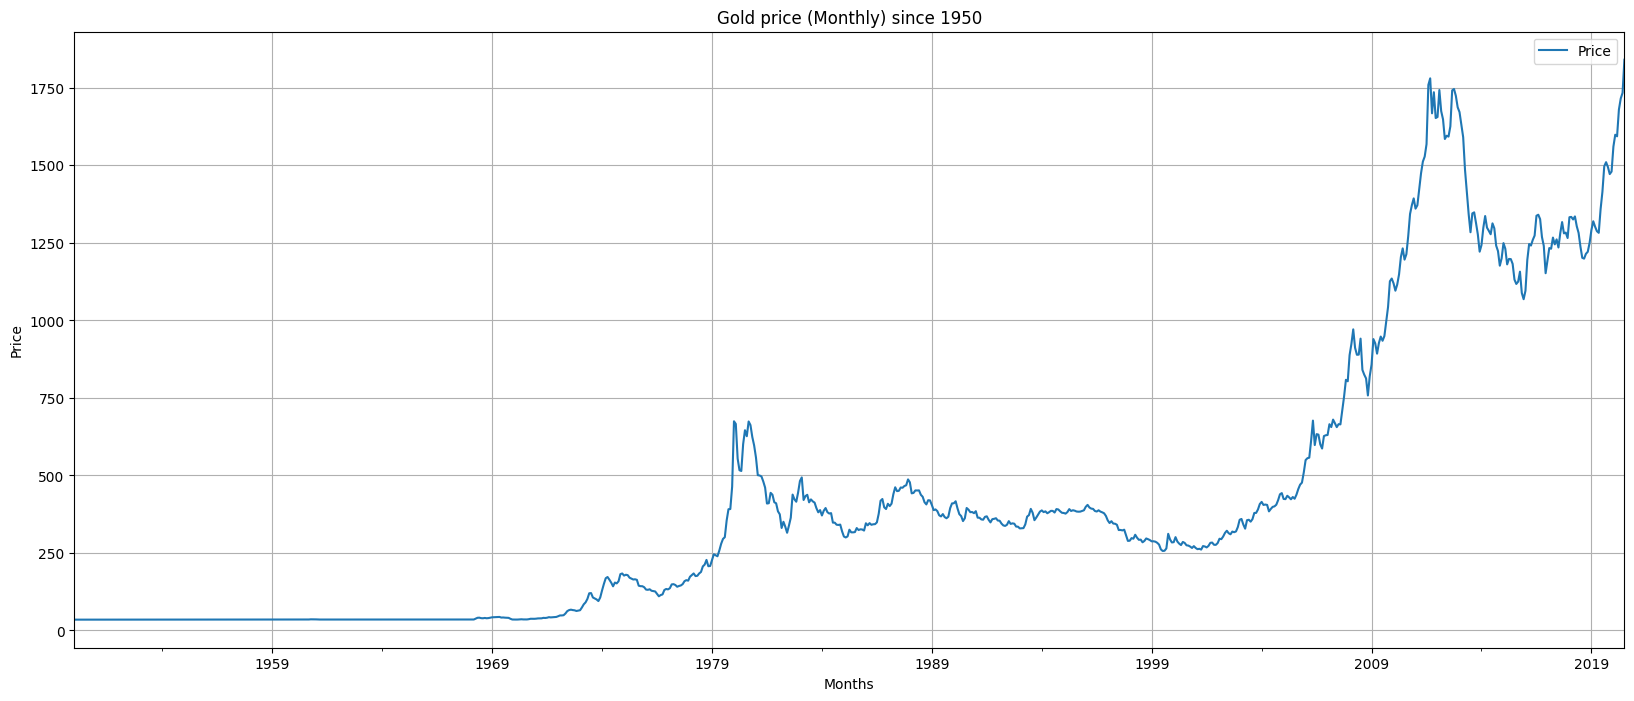

In [ ]:
df.plot(figsize=(20,8))
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

In [ ]:
round(df.describe(),3)

,Price
count,847.000
mean,416.557
std,453.665
min,34.490
25%,35.190
50%,319.622
75%,447.029
max,1840.807


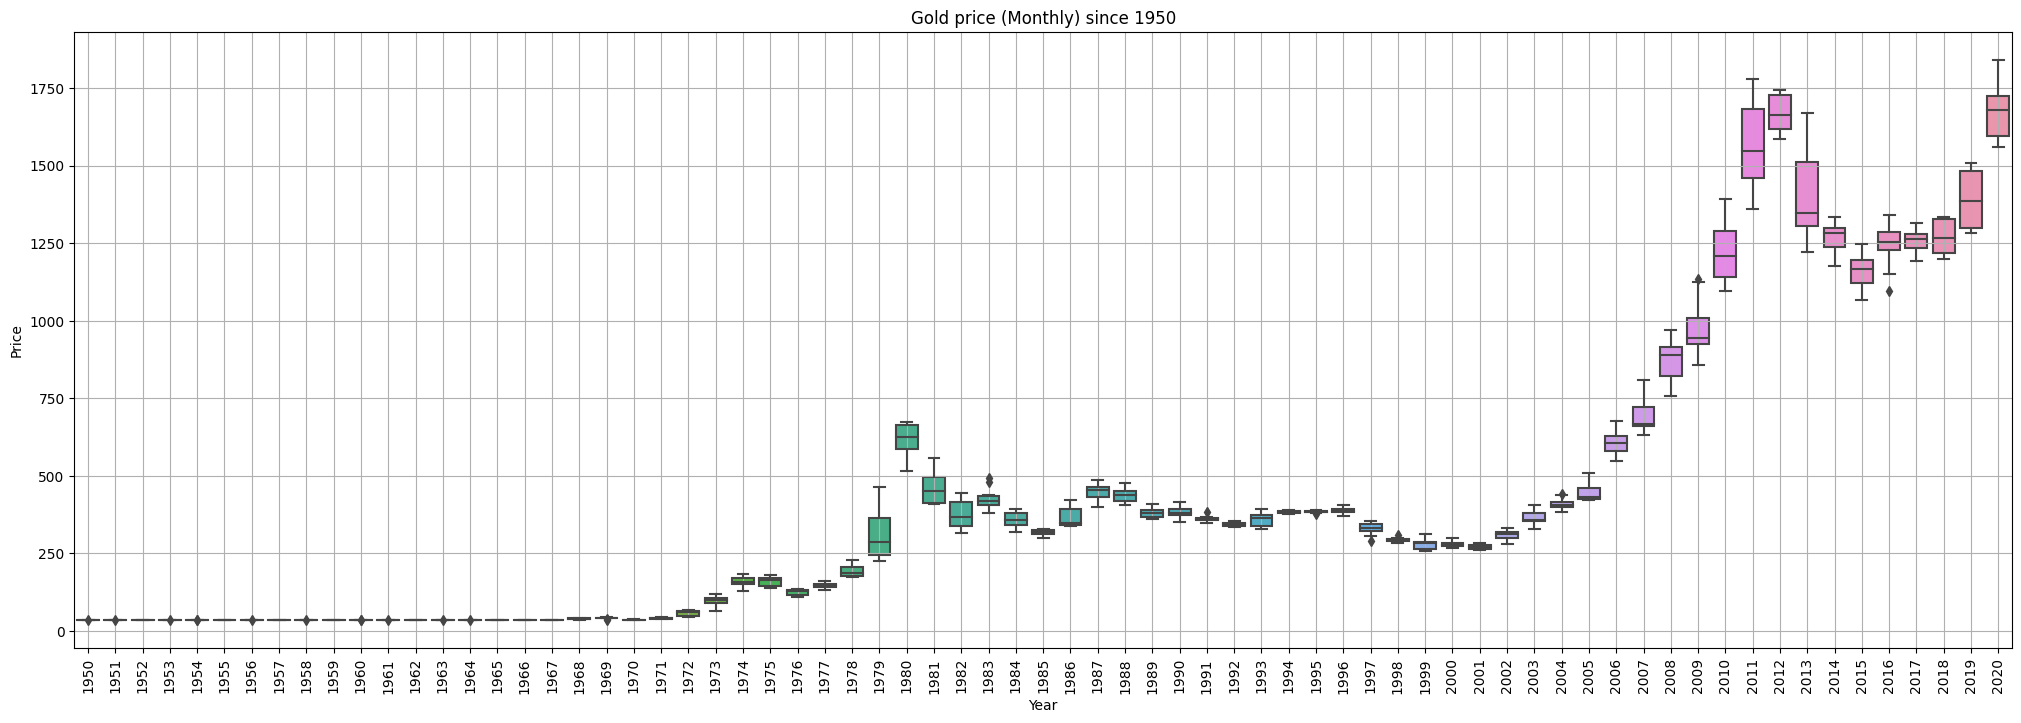

In [ ]:
_, ax = plt.subplots(figsize=(25,8))
sns.boxplot(x = df.index.year,y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.xticks(rotation=90)
plt.grid();

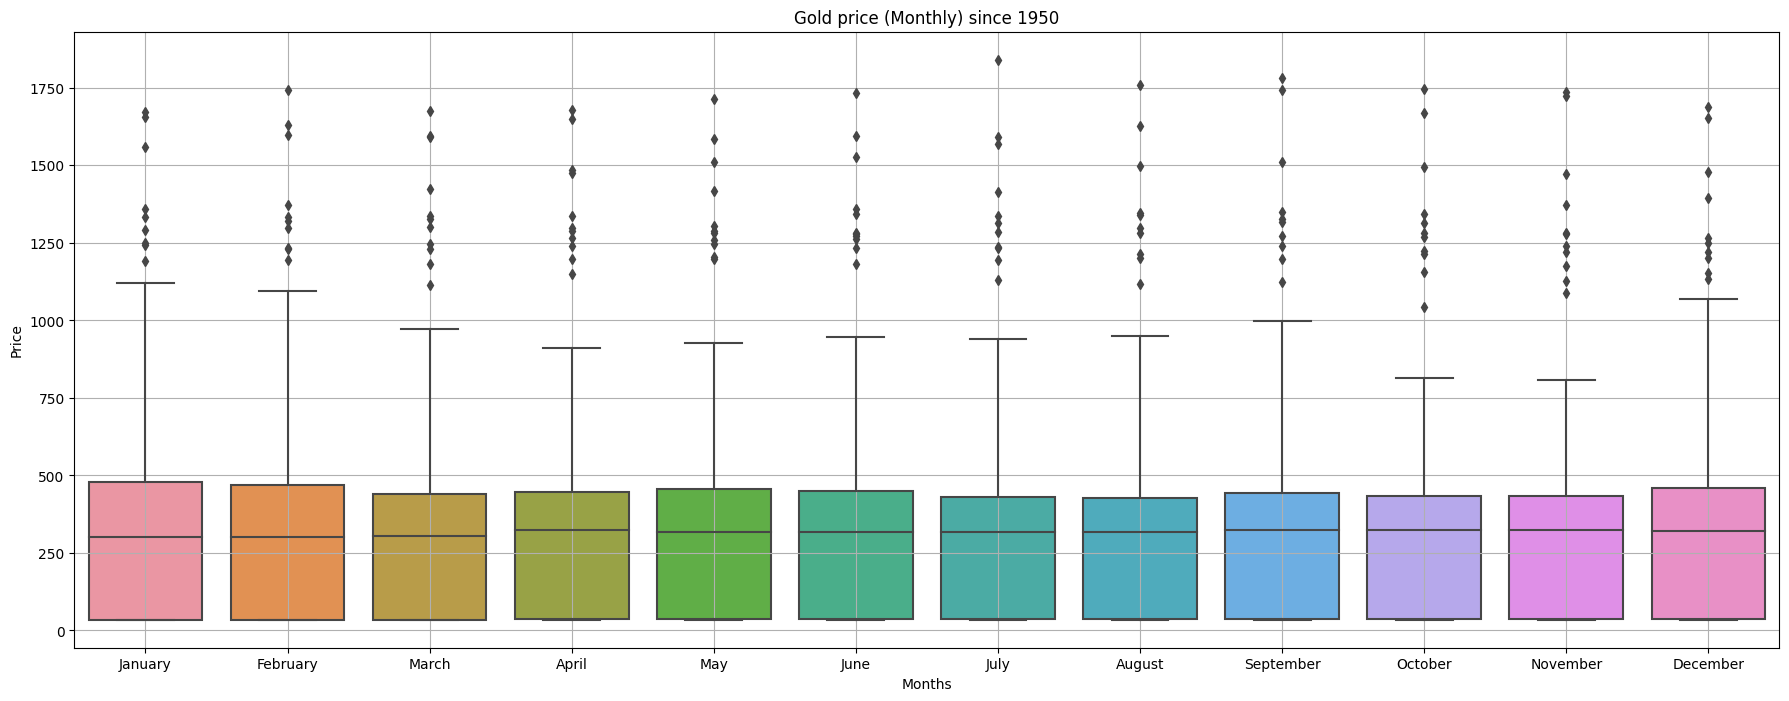

In [ ]:
_, ax = plt.subplots(figsize=(22,8))
sns.boxplot(x = df.index.month_name(),y = df.values[:,0],ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

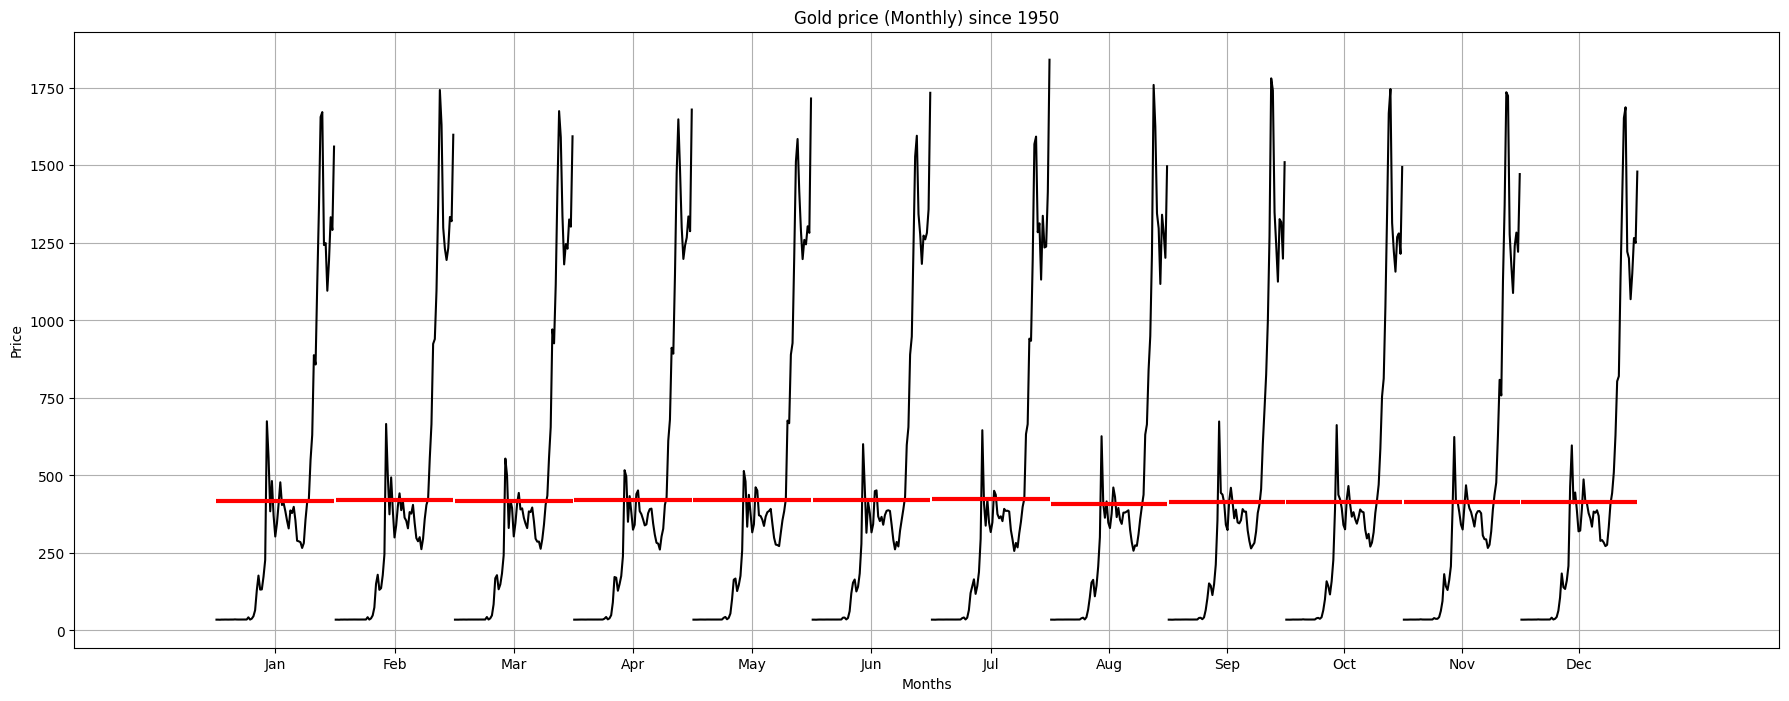

In [ ]:
from statsmodels.graphics.tsaplots import month_plot

fig, ax = plt.subplots(figsize=(22,8))

month_plot(df,ylabel='Gold price',ax=ax)
plt.title("Gold price (Monthly) since 1950")
plt.xlabel("Months")
plt.ylabel("Price")
plt.grid();

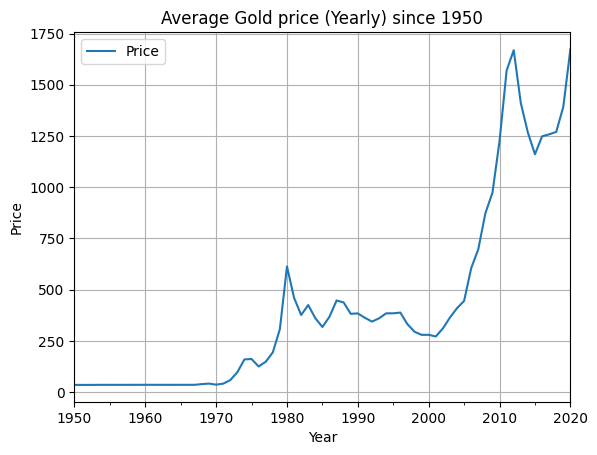

In [ ]:
# Average gold price per year trend since 1950
df_yearly_sum = df.resample('A').mean()
df_yearly_sum.plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Price")
plt.grid()

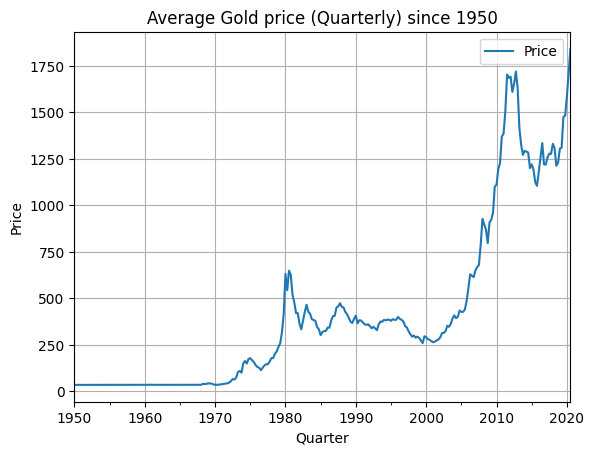

In [ ]:
# Average gold price per quarter trend since 1950
df_quarterly_sum = df.resample('Q').mean()
df_quarterly_sum.plot();
plt.title("Average Gold price (Quarterly) since 1950")
plt.xlabel("Quarter")
plt.ylabel("Price")
plt.grid()

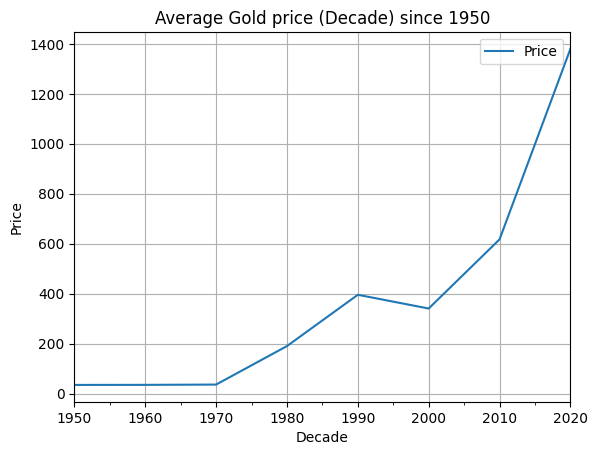

In [ ]:
# Average gold price per decade trend since 1950
df_decade_sum = df.resample('10Y').mean()
df_decade_sum.plot();
plt.title("Average Gold price (Decade) since 1950")
plt.xlabel("Decade")
plt.ylabel("Price")
plt.grid()

In [ ]:
# Coefficient of variation in price
df_1 = df.groupby(df.index.year).mean().rename(columns={'Price':'Mean'})
df_1 = df_1.merge(df.groupby(df.index.year).std().rename(columns={'Price':'Std'}),left_index=True,right_index=True)
df_1['CoV_pct'] = ((df_1['Std']/df_1['Mean'])*100).round(2)
df_1.head()

,Mean,Std,CoV_pct
month,,,
1950,34.729167,0.002887,0.01
1951,34.717500,0.020057,0.06
1952,34.628333,0.117538,0.34
1953,34.879167,0.056481,0.16
1954,35.020000,0.082792,0.24


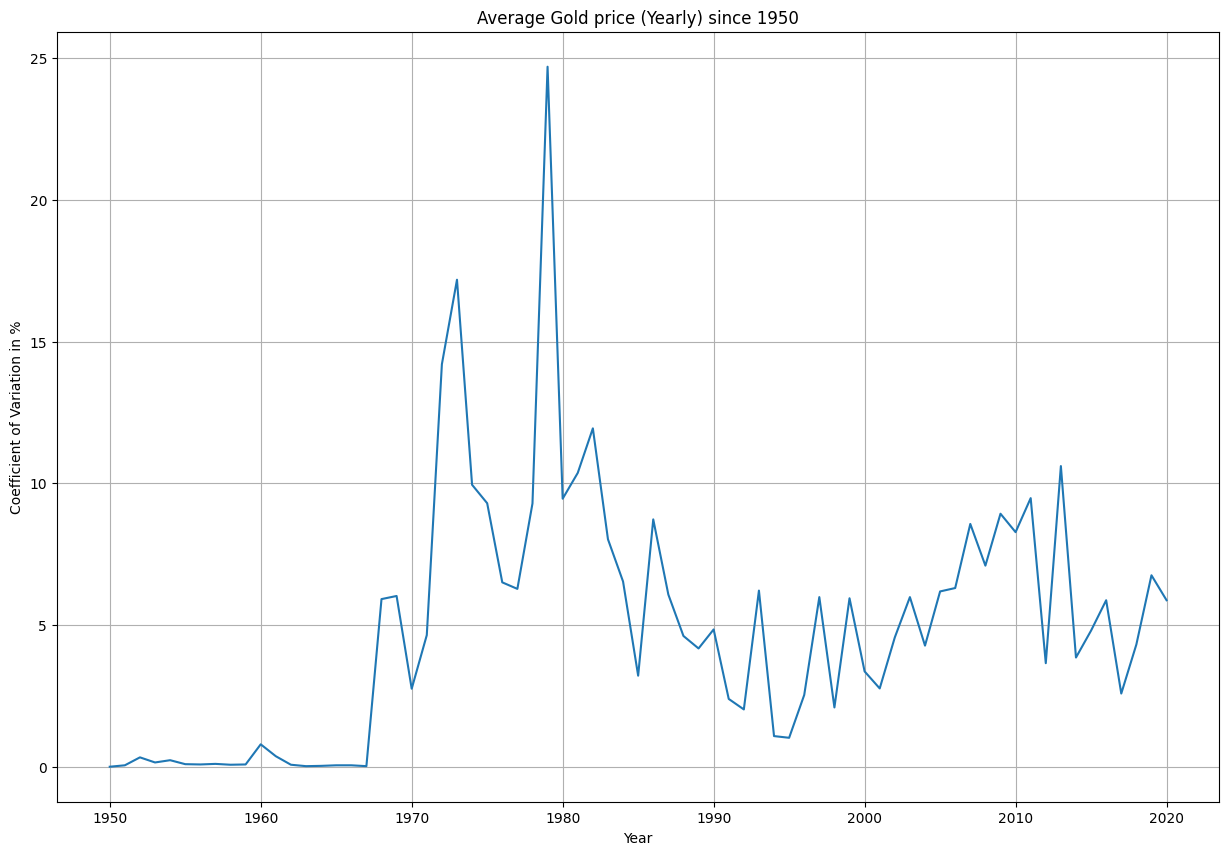

In [ ]:
# Average gold price per year trend since 1950
fig, ax = plt.subplots(figsize=(15,10))
df_1['CoV_pct'].plot();
plt.title("Average Gold price (Yearly) since 1950")
plt.xlabel("Year")
plt.ylabel("Coefficient of Variation in %")
plt.grid()

In [ ]:
train    =   df[df.index.year <= 2015]
test     =   df[df.index.year > 2015]

In [ ]:
print(train.shape)
print(test.shape)

(792, 1)
(55, 1)


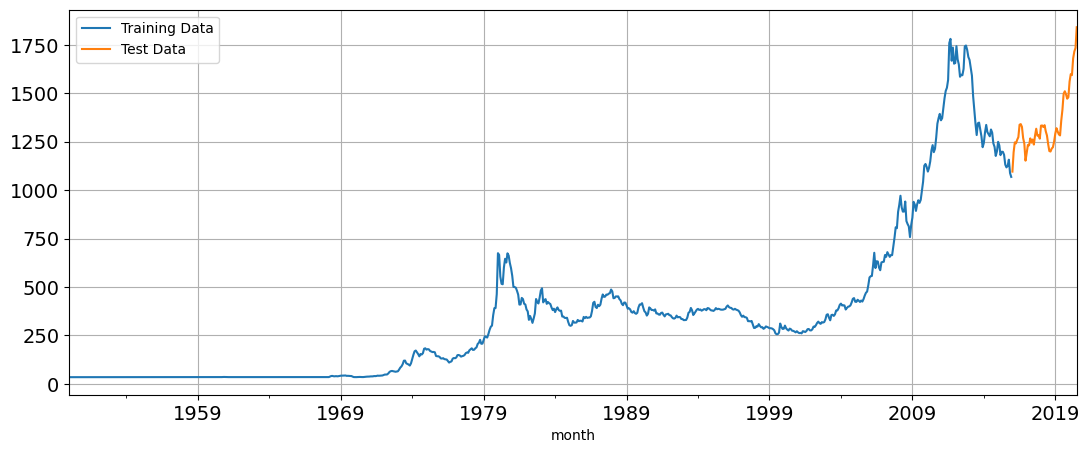

In [ ]:
train['Price'].plot(figsize=(13,5), fontsize=14)
test['Price'].plot(figsize=(13,5), fontsize=14)
plt.grid()
plt.legend(['Training Data','Test Data'])
plt.show()

In [ ]:
train_time = [i+1 for i in range(len(train))]
test_time = [i+len(train)+1 for i in range(len(test))]
len(train_time), len(test_time)

(792, 55)

In [ ]:
LR_train = train.copy()
LR_test = test.copy()

In [ ]:
LR_train['time'] = train_time
LR_test['time'] = test_time

In [ ]:
lr = LinearRegression()
lr.fit(LR_train[['time']],LR_train['Price'].values)

LinearRegression()

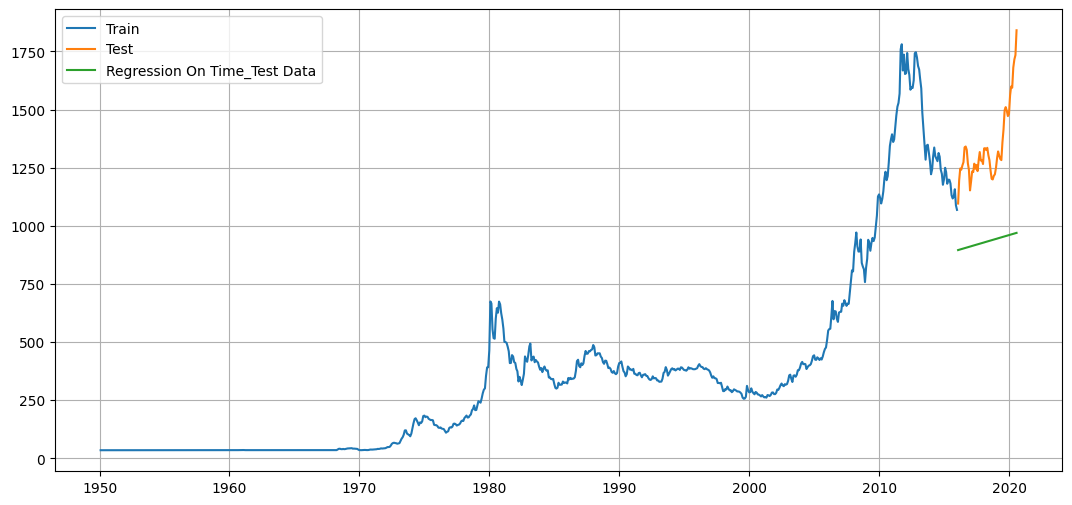

In [ ]:
test_predictions_model1         = lr.predict(LR_test[['time']])
LR_test['forecast'] = test_predictions_model1

plt.figure(figsize=(13,6))
plt.plot( train['Price'], label='Train')
plt.plot(test['Price'], label='Test')
plt.plot(LR_test['forecast'], label='Regression On Time_Test Data')
plt.legend(loc='best')
plt.grid();

In [ ]:
def mape(actual,pred):
    return round((np.mean(abs(actual-pred)/actual))*100,2)

In [ ]:
# Get MAPE of the model

mape_model1_test = mape(test['Price'].values,test_predictions_model1)
print("For RegressionOnTime forecast on the Test Data,  MAPE is %3.3f" %(mape_model1_test),"%")

For RegressionOnTime forecast on the Test Data,  MAPE is 29.760 %


In [ ]:
results = pd.DataFrame({'Test MAPE (%)': [mape_model1_test]},index=['RegressionOnTime'])
results

,Test MAPE (%)
RegressionOnTime,29.76
